## Codebasics - Bag of N grams tutorial

#### Let's first understand how to generate n-grams using CountVectorizer

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

v = CountVectorizer()
v.fit(["Thor Hathodawala is looking for a job"])
v.vocabulary_

{'thor': 5, 'hathodawala': 1, 'is': 2, 'looking': 4, 'for': 0, 'job': 3}

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

v = CountVectorizer(ngram_range=(2,2)) #using ngram_range
v.fit(["Thor Hathodawala is looking for a job"])
v.vocabulary_

{'thor hathodawala': 4,
 'hathodawala is': 1,
 'is looking': 2,
 'looking for': 3,
 'for job': 0}

In [12]:
corpus = [
    'Thor ate pizza',
    'Loki is tall',
    'Loki is eating piza'
]

In [26]:
import spacy

nlp = spacy.load('en_core_web_sm')

def preprocess(text):
    doc = nlp(text)
    filtered_tokens = []
    
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        filtered_tokens.append(token.lemma_)
        
    return" ".join(filtered_tokens)

# preprocess("Hi, how are you")

In [27]:
preprocess("Loki is eating pizza")

'Loki eat pizza'

In [29]:
corpus_processed = [preprocess(text) for text in corpus]

corpus_processed

['thor eat pizza', 'Loki tall', 'Loki eat piza']

In [30]:
v = CountVectorizer(ngram_range=(1,2))
v.fit(corpus_processed)
v.vocabulary_

{'thor': 9,
 'eat': 0,
 'pizza': 7,
 'thor eat': 10,
 'eat pizza': 2,
 'loki': 3,
 'tall': 8,
 'loki tall': 5,
 'piza': 6,
 'loki eat': 4,
 'eat piza': 1}

In [31]:
v.transform(["Thor eat pizza"]).toarray()

array([[1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1]], dtype=int64)

Let's take a document that has out of vocabulary (OOV) term and see how bag of ngram generates vector out of it

In [33]:
v.transform(["Hulk eat pizza"]).toarray()

array([[1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0]], dtype=int64)

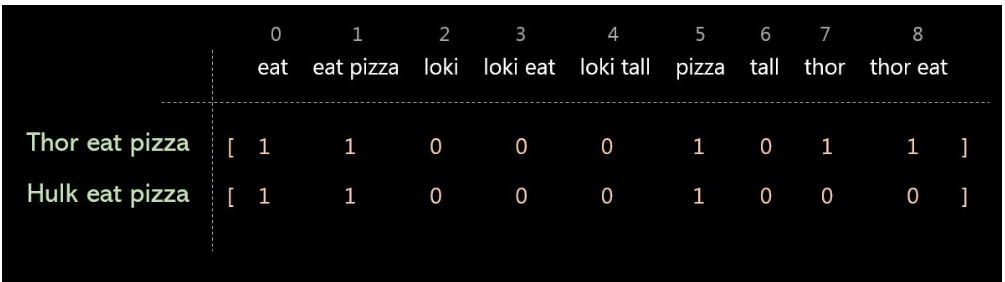

### Case study

In [36]:
import pandas as pd

df = pd.read_json('news_dataset.json')

print(df.shape)

df.head()

(12695, 2)


,text,category
0,Watching Schrödinger's Cat Die University of C...,SCIENCE
1,WATCH: Freaky Vortex Opens Up In Flooded Lake,SCIENCE
2,Entrepreneurs Today Don't Need a Big Budget to...,BUSINESS
3,These Roads Could Recharge Your Electric Car A...,BUSINESS
4,Civilian 'Guard' Fires Gun While 'Protecting' ...,CRIME


In [37]:
df.category.value_counts()

category
BUSINESS    4254
SPORTS      4167
CRIME       2893
SCIENCE     1381
Name: count, dtype: int64

In [39]:
min_samples = 1381

df_business = df[df.category=='BUSINESS'].sample(min_samples, random_state=2022)
df_sports = df[df.category=='SPORTS'].sample(min_samples, random_state=2022)
df_crime = df[df.category=='CRIME'].sample(min_samples, random_state=2022)
df_science = df[df.category=='SCIENCE'].sample(min_samples, random_state=2022)

In [40]:
df_balanced = pd.concat([df_business,df_sports,df_crime,df_science],axis=0)
df_balanced.category.value_counts()

category
BUSINESS    1381
SPORTS      1381
CRIME       1381
SCIENCE     1381
Name: count, dtype: int64

In [42]:
df_balanced['category_num'] = df_balanced.category.map({
'BUSINESS':0,
'SPORTS' :1,
'CRIME' :2,
'SCIENCE' :3 
})

In [45]:
df_balanced.sample(10)

,text,category,category_num
4866,Son Of 'Mother Of The Year' Explains His Scold...,CRIME,2
11087,Snoop Dogg Goes Off On Steelers Kicker Like On...,SPORTS,1
7351,What They Won't Tell You About Your 'Free' Cre...,BUSINESS,0
2385,It's Time For Random Street Checks To Stop In ...,CRIME,2
6128,Death Penalty Foe Allegedly Brings Meat Cleave...,CRIME,2
9540,WATCH: Bill Nye Asks If E.T. Is Worth A Cup Of...,SCIENCE,3
11012,9-Year-Old Girl Killed In Shooting Asked Polic...,CRIME,2
9918,Feds Raid Alleged 'Maternity Tourism' Hotels T...,CRIME,2
6251,"John Hinckley Jr., Reagan's Would-Be Assassin,...",CRIME,2
3692,"Amonderez Green, Teen Shot Near Ferguson, Was ...",CRIME,2


In [46]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_balanced.text,
    df_balanced.category_num,
    test_size = 0.2,
    random_state=2022,
    stratify=df_balanced.category_num
    )

In [47]:
print(X_train.shape)
X_train.head()

(4419,)


7589     Ovulating Women Prefer Images of Penetration O...
10442    Scientists Discover Spooky Influence On Baby N...
8792     Olympic Race Walker Steps Up To Propose To His...
1733     Beloved Bipedal Bear Named Pedals Believed Kil...
2526     Elizabeth Smart Gave Birth To Baby Girl, Fathe...
Name: text, dtype: object

In [49]:
y_train.value_counts()

category_num
3    1105
2    1105
0    1105
1    1104
Name: count, dtype: int64

In [54]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

clf = Pipeline([
    ('vectorizer_bow', CountVectorizer()),
    ('Multi NB', MultinomialNB())
])

clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.87      0.81       276
           1       0.93      0.80      0.86       277
           2       0.83      0.90      0.86       276
           3       0.90      0.80      0.85       276

    accuracy                           0.84      1105
   macro avg       0.85      0.84      0.84      1105
weighted avg       0.85      0.84      0.84      1105



In [57]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

clf = Pipeline([
    ('vectorizer_bow', CountVectorizer(ngram_range = (1,2))),
    ('Multi NB', MultinomialNB())
])

clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.90      0.78       276
           1       0.95      0.74      0.83       277
           2       0.82      0.88      0.85       276
           3       0.92      0.78      0.84       276

    accuracy                           0.82      1105
   macro avg       0.85      0.82      0.83      1105
weighted avg       0.85      0.82      0.83      1105



In [59]:
X_test[:5]

3716     African Nation Slaps Exxon With Fine Nearly 7 ...
608      These Cringe-Worthy Stories Show It Can Be Har...
11172    LISTEN: The Accidental Discovery That Proved T...
1346     Build Loyalty -- The Cost -- $00.00 Remember y...
1356     Man Killed By Michigan Police Wasn't Targeting...
Name: text, dtype: object

In [60]:
y_test[:5]

3716     0
608      3
11172    3
1346     0
1356     2
Name: category_num, dtype: int64

In [61]:
y_pred[:5]

array([0, 0, 3, 0, 2], dtype=int64)

Business : 0

Sports: 1

Crime: 2

Science: 3

### Apply preprocessed text

In [62]:
df_balanced['preprocessed_txt'] = df_balanced.text.apply(preprocess)

In [63]:
df_balanced.head()

,text,category,category_num,preprocessed_txt
11967,GCC Business Leaders Remain Confident in the F...,BUSINESS,0,GCC Business Leaders remain Confident Face Reg...
2912,From the Other Side; an Honest Review from Emp...,BUSINESS,0,Honest Review employee wake morning love impor...
3408,"Mike McDerment, CEO of FreshBooks, Talks About...",BUSINESS,0,Mike McDerment ceo FreshBooks Talks give build...
502,How to Market Your Business While Traveling th...,BUSINESS,0,market business travel World recently amazing ...
5279,How to Leverage Intuition in Decision-making I...,BUSINESS,0,Leverage intuition decision making feel safe r...


In [64]:
X_train, X_test, y_train, y_test = train_test_split(
    df_balanced.preprocessed_txt,
    df_balanced.category_num,
    test_size = 0.2,
    random_state=2022,
    stratify=df_balanced.category_num
    )

In [65]:
clf = Pipeline([
    ('vectorizer_bow', CountVectorizer(ngram_range = (1,2))),
    ('Multi NB', MultinomialNB())
])

clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.88      0.84       276
           1       0.92      0.82      0.87       277
           2       0.83      0.92      0.87       276
           3       0.90      0.81      0.85       276

    accuracy                           0.86      1105
   macro avg       0.86      0.86      0.86      1105
weighted avg       0.86      0.86      0.86      1105

